In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torchvision.models as models
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import torch.nn.functional as F

In [3]:
transform_all = T.Compose([
    T.Resize((224, 224)),   # paksa seragam
    T.ToTensor(),
])

In [4]:
data_root = "data"   # Ubah sesuai directory Anda
full_dataset = ImageFolder(data_root, transform=transform_all)
num_classes = len(full_dataset.classes)

# split dataset otomatis
train_size = int(0.7 * len(full_dataset))
val_size   = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [5]:
class ResNetBottleneck(nn.Module):
    def __init__(self, in_channels, filters):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, filters, 1)
        self.bn1 = nn.BatchNorm2d(filters)

        self.conv2 = nn.Conv2d(filters, filters, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(filters)

        self.conv3 = nn.Conv2d(filters, filters * 4, 1)
        self.bn3 = nn.BatchNorm2d(filters * 4)

        self.shortcut_needed = (in_channels != filters * 4)
        if self.shortcut_needed:
            self.shortcut_conv = nn.Conv2d(in_channels, filters * 4, 1)

    def forward(self, x):
        shortcut = x
        if self.shortcut_needed:
            shortcut = self.shortcut_conv(x)

        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))

        return torch.relu(x + shortcut)


class HybridMobileNet(nn.Module):
    def __init__(self, num_classes=4, dropout=0.3):
        super().__init__()

        self.base = models.mobilenet_v3_small(
            weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1
        )

        self.base.features.requires_grad_(False)

        # ambil channel output terakhir
        in_channels = self.base.features[-1].out_channels  # = 576

        self.b1 = ResNetBottleneck(in_channels, 64)   # 576 → 256
        self.b2 = ResNetBottleneck(64 * 4, 64)        # 256 → 256

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(64 * 4, num_classes)      # 256 → num_classes

    def forward(self, x):
        x = self.base.features(x)
        x = self.b1(x)
        x = self.b2(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)

In [6]:

import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, class_names, figsize=(8,6)):
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest')
    plt.title("Confusion Matrix")
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Label angka di kotak
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "white")

    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

def classification_report_df(y_true, y_pred, class_names):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    df = pd.DataFrame(report).transpose()
    return df

def evaluate_model(model, dataloader, device, class_names):
    start_time = time.perf_counter()
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    cm = confusion_matrix(all_labels, all_preds)

    return {
        "confusion_matrix": cm,
        "preds": all_preds,
        "labels": all_labels,
        "time": elapsed_time
    }

def clean_gpu():
    for var in list(globals().keys()):
        if isinstance(globals()[var], torch.Tensor):
            del globals()[var]

    import gc
    gc.collect()
    torch.cuda.synchronize()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
def pipeline(model, loader):
    #Summary(file_name, epochs, train_losses, val_losses, train_accs, val_accs, elapsed_time)
    results = evaluate_model(model, loader, device, full_dataset.classes)
    plot_confusion_matrix(results["confusion_matrix"], full_dataset.classes)
    df_report = classification_report_df(results["labels"], results["preds"], full_dataset.classes)
    display(df_report)

In [9]:
# bagian dari hasil optimasi meta-heuristic
# file_name = "mobresnet-0.9777914867365823.pth"
# lr = 0.002436480254538437
# wd = 0.00038149522174769695
# do = 0.3825048389178911

file_name = "mobresnet-0.9827267119062307.pth"
lr = 0.0011941196359066242 # hanya untuk training
wd = 0.0007233874347635777 # hanya untuk training
do = 0.21222920791578329
model_path = "./pso/" + file_name

model1 = HybridMobileNet(num_classes=4, dropout=do).to(device)

state_dict = torch.load(model_path, weights_only=True)

# Load the state dictionary into your model
model1.load_state_dict(state_dict)

#optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

<All keys matched successfully>

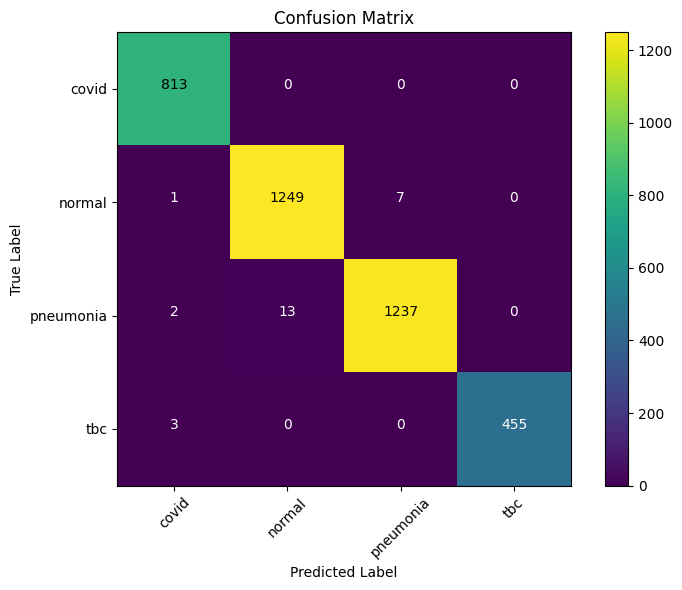

,precision,recall,f1-score,support
covid,0.992674,1.000000,0.996324,813.000000
normal,0.989699,0.993636,0.991663,1257.000000
pneumonia,0.994373,0.988019,0.991186,1252.000000
tbc,1.000000,0.993450,0.996714,458.000000
accuracy,0.993122,0.993122,0.993122,0.993122
macro avg,0.994186,0.993776,0.993972,3780.000000
weighted avg,0.993135,0.993122,0.993119,3780.000000


In [10]:
pipeline(model1, train_loader)

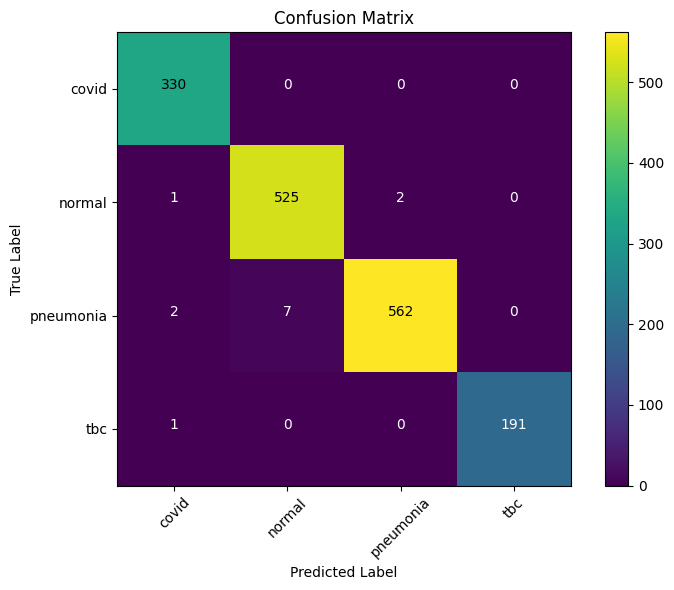

,precision,recall,f1-score,support
covid,0.988024,1.000000,0.993976,330.00000
normal,0.986842,0.994318,0.990566,528.00000
pneumonia,0.996454,0.984238,0.990308,571.00000
tbc,1.000000,0.994792,0.997389,192.00000
accuracy,0.991980,0.991980,0.991980,0.99198
macro avg,0.992830,0.993337,0.993060,1621.00000
weighted avg,0.992027,0.991980,0.991978,1621.00000


In [11]:
pipeline(model1, val_loader)

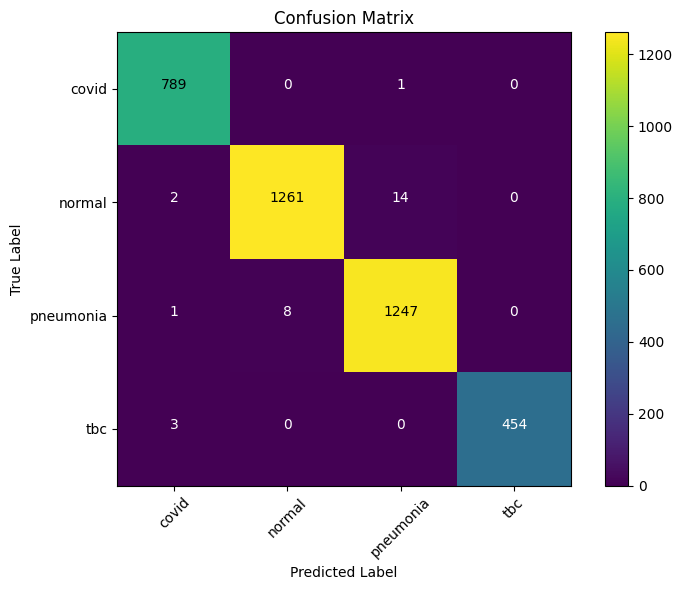

,precision,recall,f1-score,support
covid,0.992453,0.998734,0.995584,790.000000
normal,0.993696,0.987471,0.990573,1277.000000
pneumonia,0.988114,0.992834,0.990469,1256.000000
tbc,1.000000,0.993435,0.996707,457.000000
accuracy,0.992328,0.992328,0.992328,0.992328
macro avg,0.993566,0.993119,0.993333,3780.000000
weighted avg,0.992344,0.992328,0.992327,3780.000000


In [30]:
# bagian dari hasil optimasi meta-heuristic
file_name = "mobresnet-0.9777914867365823.pth"
lr = 0.002436480254538437
wd = 0.00038149522174769695
do = 0.3825048389178911

model_path = "./pso/" + file_name

model2 = HybridMobileNet(num_classes=4, dropout=do).to(device)

state_dict = torch.load(model_path, weights_only=True)

# Load the state dictionary into your model
model2.load_state_dict(state_dict)

#optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

pipeline(model2, train_loader)

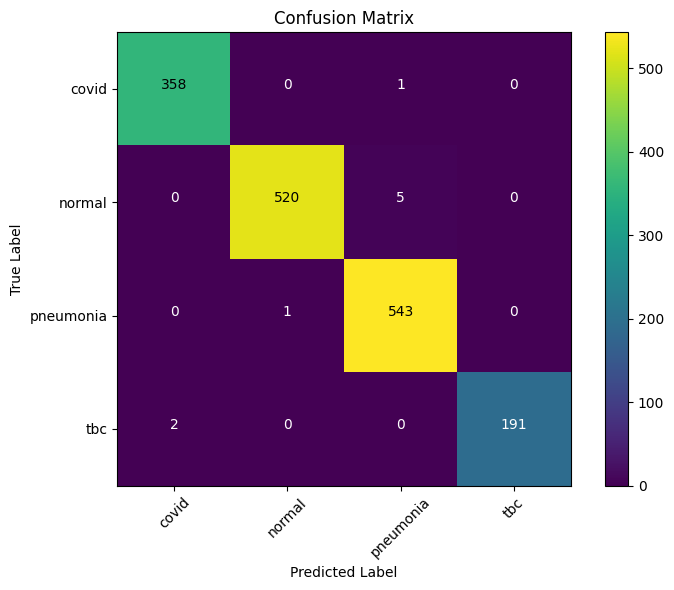

,precision,recall,f1-score,support
covid,0.994444,0.997214,0.995828,359.000000
normal,0.998081,0.990476,0.994264,525.000000
pneumonia,0.989071,0.998162,0.993596,544.000000
tbc,1.000000,0.989637,0.994792,193.000000
accuracy,0.994448,0.994448,0.994448,0.994448
macro avg,0.995399,0.993872,0.994620,1621.000000
weighted avg,0.994480,0.994448,0.994449,1621.000000


In [31]:
pipeline(model2, val_loader)

In [9]:
#model_vgg16.parameters()
model_parameters = filter(lambda p: p.requires_grad, model1.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])


np.int64(1926636)

In [2]:
import hiddenlayer as hl

In [12]:
batch = next(iter(train_loader))

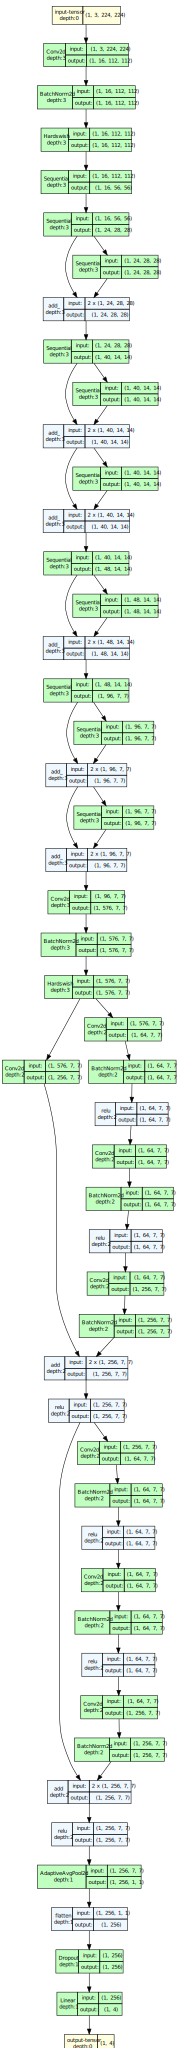

In [32]:
#import torchvision
from torchview import draw_graph


model_graph = draw_graph(model1, input_size=(1, 3, 224, 224), expand_nested=False, graph_name='model_graph', save_graph=True, filename='model_graph')
model_graph.visual_graph

In [31]:
model_graph.visual_graph.render(filename='model_architecture', format='png')

'model_architecture.png'

In [28]:
pip uninstall torchview

^C
Note: you may need to restart the kernel to use updated packages.


In [ ]:
conda install python-graphviz